In [1]:
import gc
import logging
logging.disable(logging.WARNING)
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
import tensorflow_probability as tfp
import tensorflow_addons as tfa

mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

2.6.3


In [2]:
# Load data
df = pd.read_parquet('E:/train_low_mem.parquet')
df.drop(['row_id'], inplace=True, axis=1)
y = df.pop("target")

investment_id = df.pop("investment_id")
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(investment_id)

In [3]:
def preprocess(x, y):
    # flatten and normalize
    return x, tf.math.sign(y) * tf.math.log1p(tf.math.log1p(tf.math.abs(y)))

def post_process(y):
    y = list(map(np.ndarray.item, list(y)))
    y = tf.math.sign(y) * (tf.math.expm1(tf.math.expm1(tf.math.sign(y) * y)))
    return y.numpy()

def make_dataset(feature, investment_id, y, batch_size=8192, mode='train'):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train": ds = ds.shuffle(8192, seed=69)  # only shuffle when training
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


# Pearson correlation coefficient loss and metrics
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops

def t(a):
  """For testing: generate a float32 tensor from anything."""
  return tf.constant(a, dtype=tf.float32)

def tmean(x, axis=-1):
  """Arithmetic mean of a tensor over some axis, default last."""
  x = tf.convert_to_tensor(x)
  sum = tf.reduce_sum(x, axis=axis)
  n = tf.cast(tf.shape(x)[axis], x.dtype)
  return sum / n

def correlationMetric(x, y, axis=-2):
  """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
  x = tf.convert_to_tensor(x)
  y = math_ops.cast(y, x.dtype)
  n = tf.cast(tf.shape(x)[axis], x.dtype)
  xsum = tf.reduce_sum(x, axis=axis)
  ysum = tf.reduce_sum(y, axis=axis)
  xmean = xsum / n
  ymean = ysum / n
  xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
  yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
  cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
  corr = cov / tf.sqrt(xvar * yvar)
  return tf.constant(1.0, dtype=x.dtype) - corr


def correlationLoss(x,y, axis=-2):
  """Loss function that maximizes the pearson correlation coefficient between the predicted values and the labels,
  while trying to have the same mean and variance"""
  x = tf.convert_to_tensor(x)
  y = math_ops.cast(y, x.dtype)
  n = tf.cast(tf.shape(x)[axis], x.dtype)
  xsum = tf.reduce_sum(x, axis=axis)
  ysum = tf.reduce_sum(y, axis=axis)
  xmean = xsum / n
  ymean = ysum / n
  xsqsum = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
  ysqsum = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)
  cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
  corr = cov / tf.sqrt(xsqsum * ysqsum)
  sqdif = tf.reduce_sum(tf.math.squared_difference(x, y), axis=axis) / n / tf.sqrt(ysqsum / n)
  return tf.convert_to_tensor( K.mean(tf.constant(1.0, dtype=x.dtype) - corr + (0.01 * sqdif)) , dtype=tf.float32 )


In [4]:
from tensorflow.keras import layers
from tensorflow import keras
def dnn_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(128)(investment_id_x)
    investment_id_x = tfa.activations.mish(investment_id_x)
    investment_id_x = layers.Dense(64)(investment_id_x)
    investment_id_x = tfa.activations.mish(investment_id_x)
    investment_id_x = layers.Dense(32)(investment_id_x)
    investment_id_x = tfa.activations.mish(investment_id_x)

    feature_x = layers.Dense(256)(features_inputs)
    feature_x = tfa.activations.mish(feature_x)
    feature_x = layers.Dense(128)(feature_x)
    feature_x = tfa.activations.mish(feature_x)
    feature_x = layers.Dense(64)(feature_x)
    feature_x = tfa.activations.mish(feature_x)

    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(256, kernel_regularizer="l2")(x)
    x = tfa.activations.mish(x)
    x = layers.Dense(128, kernel_regularizer="l2")(x)
    x = tfa.activations.mish(x)
    x = layers.Dense(32, kernel_regularizer="l2")(x)
    x = tfa.activations.mish(x)

    opt = tfa.optimizers.RectifiedAdam(1e-3)
    opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
    output = layers.Dense(1, dtype=tf.float32)(x)
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=opt, loss=correlationLoss, metrics=['mse', "mae", correlationMetric])
    return model

def lstm_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(128, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(32, activation='swish')(investment_id_x)

    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(128, activation='swish')(feature_x)
    feature_x = layers.Dense(64, activation='swish')(feature_x)

    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(256, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)


    x = layers.BatchNormalization(name='batch_norm1')(x)
    x = layers.Dense(256, activation='swish', name='dense1')(x)
    x = layers.Dropout(0.1, name='dropout1')(x)
    x = layers.Reshape((1, -1), name='reshape1')(x)
    x = layers.BatchNormalization(name='batch_norm2')(x)
    x = layers.LSTM(128, return_sequences=True, name='lstm1')(x)
    x = layers.LSTM(16, return_sequences=False, name='lstm2')(x)

    opt = tfa.optimizers.RectifiedAdam(1e-3)
    opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
    output = layers.Dense(1, dtype=tf.float32)(x)
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss=correlationLoss, metrics=['mse', "mae", correlationMetric])
    return model


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        114560      integer_lookup[0][0]             
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32)           0           embedding[0][0]                  
______________________________________________________________________________________________

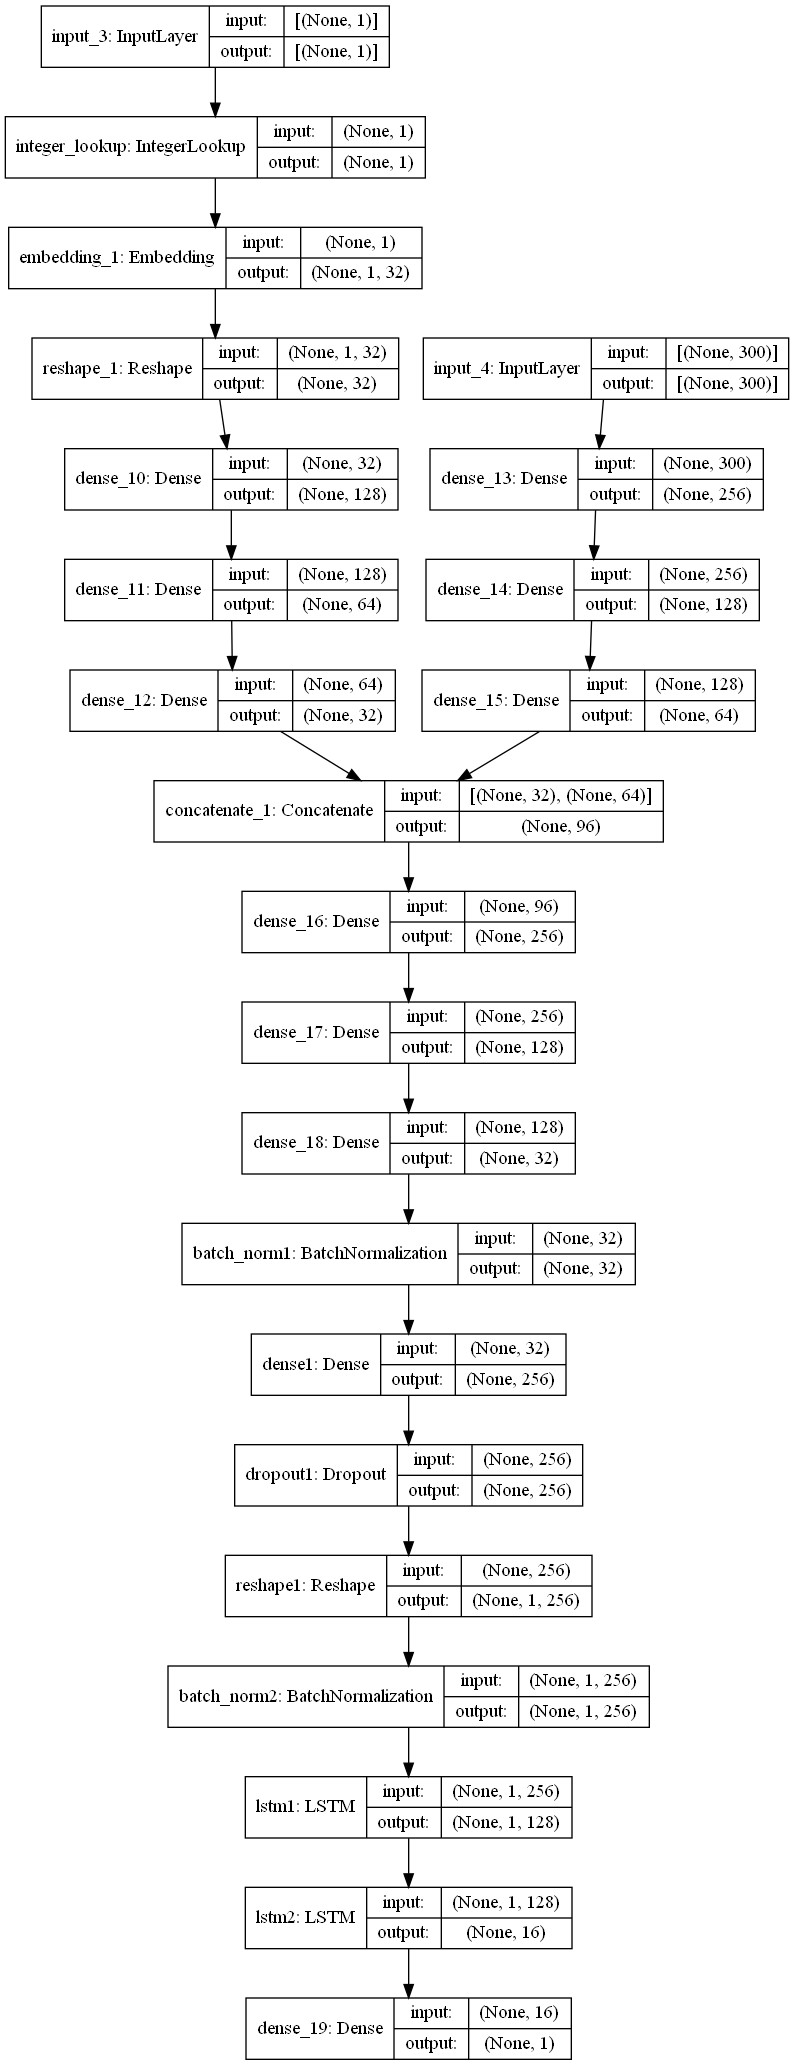

In [5]:
dnn = dnn_model()
dnn.summary()
plot_model(dnn, to_file='dnn.png', show_shapes=True)
lstm_model = lstm_model()
lstm_model.summary()
plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True)

In [7]:
import scipy
from sklearn.model_selection import StratifiedKFold
opt = tfa.optimizers.RectifiedAdam(1e-3)
opt = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)
# group_time_series_split = GroupTimeSeriesSplit(n_folds=6, holdout_size=200, groups=df['time_id'])
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(df, investment_id)):
    print(f'Model {index}')
    X_train, X_val = df.iloc[train_indices].loc[:, df.columns != 'time_id'], df.iloc[valid_indices].loc[:, df.columns != 'time_id']
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = dnn_model()
    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_{index}", monitor='val_correlationMetric', save_best_only=True, mode='min'),
                 tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_correlationMetric', verbose=1, restore_best_weights=True, mode='min'),
                 tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=4, verbose=1, monitor='val_correlationMetric', mode='min')]
    history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=callbacks)
    models.append(load_model(f"model_{index}", custom_objects={'correlationLoss': correlationLoss, 'correlationMetric': correlationMetric, 'Addons>Lookahead': opt}))

    # pearson_score = scipy.stats.pearsonr(post_process(model.predict(valid_ds)), y_val.values)[0]
    # print('Pearson:', pearson_score)
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    del model
    gc.collect()

C:\Program Files\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Model 0
Epoch 1/50
307/307 [==============================] - 29s 80ms/step - loss: 3.7435 - mse: 0.1893 - mae: 0.3461 - correlationMetric: 0.9036 - val_loss: 2.7207 - val_mse: 0.2098 - val_mae: 0.3588 - val_correlationMetric: 0.8888
Epoch 2/50
307/307 [==============================] - 7s 22ms/step - loss: 1.9175 - mse: 0.1856 - mae: 0.3455 - correlationMetric: 0.8702 - val_loss: 1.3562 - val_mse: 0.1903 - val_mae: 0.3502 - val_correlationMetric: 0.8785
Epoch 3/50
307/307 [==============================] - 6s 18ms/step - loss: 1.0987 - mse: 0.1787 - mae: 0.3409 - correlationMetric: 0.8597 - val_loss: 0.9689 - val_mse: 0.1860 - val_mae: 0.3465 - val_correlationMetric: 0.8746
Epoch 4/50
307/307 [==============================] - 5s 18ms/step - loss: 0.9051 - mse: 0.1792 - mae: 0.3404 - correlationMetric: 0.8533 - val_loss: 0.8988 - val_mse: 0.1876 - val_mae: 0.3465 - val_correlationMetric: 0.8724
Epoch 5/50
307/307 [==============================] - 6s 18ms/step - loss: 0.8679 - mse: 0.

In [8]:
import scipy
X_train, y_train = df.loc[:, df.columns != 'time_id'], y
investment_id_train = investment_id
# train_ds = make_dataset(X_train, investment_id_train, y_train)
model = build_model()
callbacks = [tf.keras.callbacks.ModelCheckpoint(f"model_comb", monitor='val_mse', save_best_only=True, mode='min'),
             tf.keras.callbacks.EarlyStopping(patience=13, monitor='val_mse', verbose=1, restore_best_weights=True, mode='min'),
             tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=6, verbose=1, monitor='val_mse', mode='min'),
             tf.keras.callbacks.TerminateOnNaN()]
history = model.fit({'inv_id_in': investment_id_train, 'feature_in': X_train}, y_train, batch_size=8192, epochs=100, validation_split=0.2, callbacks=callbacks)

NameError: name 'build_model' is not defined

In [9]:
from ubiquantEmulator import TimeSeriesAPI

def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0

def post_process(y):
    y = list(map(np.ndarray.item, list(y)))
    y = tf.math.sign(y) * (tf.math.expm1(tf.math.expm1(tf.math.sign(y) * y)))
    return y.numpy()

def make_test_dataset(feature, investment_id, batch_size=8192):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds


def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(post_process(y_pred))
    return np.mean(y_preds, axis=0)  # ensemble

models = [load_model(f"model_{index}", custom_objects={'correlationLoss': correlationLoss, 'correlationMetric': correlationMetric, 'Addons>Lookahead': opt}) for index in range(5)]
# models = [load_model(f"model_comb", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss})]
# models += [load_model(f"1/model_{index}", custom_objects={'pearson_corr': pearson_corr, 'pearson_corr_loss': pearson_corr_loss}) for index in range(6)]
# test = pd.read_parquet('E:/train_low_mem.parquet')
# time_ids = df['time_id'].unique()
# test = test.loc[test['time_id'].isin(time_ids)]  # take last 200 time id rows from df
test = pd.read_csv('kaggle/input/ubiquant-market-prediction/train.csv', engine='pyarrow')
iter_test = TimeSeriesAPI(test)
for n, (test_df, sample_prediction_df) in enumerate(iter_test):
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    iter_test.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {iter_test.score()}')

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
       row_id    target
18211     8_1 -0.075679
18212     8_2  0.139700
18213     8_6  0.464156
18214     8_7 -0.372138
18215     8_8  0.023539
...       ...       ...
19995  8_2961 -0.135789
19996  8_2963  0.241808
19997  8_2964 -0.679146
19998  8_2965 -0.282874
19999  8_2966  0.072935

[1789 rows x 2 columns]
Pearson: (       row_id    target  prediction
0         0_1 -0.300875    0.279513
1         0_2 -0.231040   -0.041929
2         0_6  0.568807    0.400092
3         0_7 -1.064780   -0.284197
4         0_8 -0.531940    0.060848
...       ...       ...         ...
19995  8_2961  2.395875   -0.135789
19996  8_2963  0.293830    0.241808
19997  8_2964  0.295464   -0.679146
19998  8_2965 -0.722136   -0.282874
19999  8_2966 -0.268326    0.072935

[20000 rows x 3 columns], 0.13275043333333866)


In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df.loc[:, 'f_0':'f_299'], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)
print(sample_prediction_df)
print(f'Pearson: {scipy.stats.pearsonr(sample_prediction_df["target"].values, test_df["target"].values)[0]}')

ModuleNotFoundError: No module named 'ubiquant'